In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import glob
from PIL import Image
import torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.optim as optim
import torch.autograd as ag
from sklearn.model_selection import train_test_split

print(os.listdir("/datasets/ee285f-public/human-protein"))

['sample_submission.csv', 'train', 'test', 'train.csv']


In [2]:
random.seed( 42 )

In [3]:
use_gpu = torch.cuda.device_count() > 0
print("{} GPU's available:".format(torch.cuda.device_count()) )

1 GPU's available:


In [4]:
base_dir = "/datasets/ee285f-public/human-protein"
train_image_dir = os.path.join(base_dir, 'train')
test_image_dir = os.path.join(base_dir, 'test')

In [5]:
df_train = pd.read_csv(base_dir + '/train.csv')
df_test = pd.DataFrame()

In [6]:
df_train['path'] = df_train['Id'].map(lambda x: os.path.join(train_image_dir, '{}_green.png'.format(x)))
df_train['target_list'] = df_train['Target'].map(lambda x: [int(a) for a in x.split(' ')])

df_test['path'] = glob.glob(os.path.join(test_image_dir, '*.png'))

In [7]:
df_train.head()

,Id,Target,path,target_list
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,/datasets/ee285f-public/human-protein/train/00...,"[16, 0]"
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,/datasets/ee285f-public/human-protein/train/00...,"[7, 1, 2, 0]"
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,/datasets/ee285f-public/human-protein/train/00...,[5]
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,/datasets/ee285f-public/human-protein/train/00...,[1]
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,/datasets/ee285f-public/human-protein/train/00...,[18]


In [8]:
X = df_train['path'].values
print(X.shape)
y = df_train['target_list'].values

X_test = df_test['path'].values

(31072,)


In [9]:
class CellsDataset(Dataset):

    def __init__(self, X, y=None, transforms=None, nb_organelle=28):
        
        self.nb_organelle = nb_organelle
        self.transform = transforms 
        self.X = X
        self.y = y
            
    def open_rgby(self, path2data): #a function that reads RGBY image
        
        Id = path2data.split('/')[-1].split('_')[0]
        basedir = '/'.join(path2data.split('/')[:-1])
        
        images = np.zeros(shape=(512,512,3))
        colors = ['red','green','blue']
        for i, c in enumerate(colors):
            images[:,:,i] = np.asarray(Image.open(basedir + '/' + Id + '_' + c + ".png"))
        
            yellow_ch = np.asarray(Image.open(basedir + '/' + Id + '_yellow.png'))
            images[:,:,0] += (yellow_ch/2).astype(np.uint8) 
            images[:,:,1] += (yellow_ch/2).astype(np.uint8)
            #print(images.shape)
        
        return images.astype(np.uint8)
    
    def __getitem__(self, index):
        
        path2img = self.X[index]
        image = self.open_rgby(path2img)

        if self.y is None:
            labels =np.zeros(self.nb_organelle,dtype=np.int)
        else:
            label = np.eye(self.nb_organelle,dtype=np.float)[self.y[index]].sum(axis=0)
        
        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.X)

In [10]:
class AdjustGamma(object):
    def __call__(self, img):
        return transforms.functional.adjust_gamma(img, 0.8, gain=1)

In [11]:
class AdjustContrast(object):
    def __call__(self, img):
        return transforms.functional.adjust_contrast(img, 2)

In [12]:
class AdjustBrightness(object):
    def __call__(self, img):
        return transforms.functional.adjust_brightness(img, 2)

In [13]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))
    img = std * inp + mean
    return img

In [14]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(), # because the input dtype is numpy.ndarray
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AdjustGamma(),
        AdjustContrast(),
        ##AdjustBrightness(),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=42)

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(
     X_train, y_train, test_size=0.25, random_state=42)

In [17]:
dsets = {
    'train': CellsDataset(X_train, y_train, transforms=data_transforms['train']),
    'valid': CellsDataset(X_valid, y_valid, transforms=data_transforms['test']),
    'test':  CellsDataset(X_test, y_test,  transforms=data_transforms['test']),
}

In [18]:
batch_size = 32
random_seed = 3
valid_size = 0.4
shuffle = True

In [19]:
def create_dataLoader(dsets, batch_size, shuffle=False, pin_memory=False):
    
    dset_loaders = {} 
    for key in dsets.keys():
        if key == 'test':
            dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, pin_memory=pin_memory, shuffle=False)
        else:
            dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, pin_memory=pin_memory, shuffle=True)
    return dset_loaders

In [20]:
dset_loaders = create_dataLoader(dsets, batch_size, shuffle, pin_memory=False)

In [21]:
dset_loaders.keys()

['test', 'train', 'valid']

In [22]:
def plot_organelles(dset_loaders, is_train = True, preds_test = [], preds_train = []):
    
    X, y = next(iter(dset_loaders))
    X, y = X.numpy(), y.numpy()
    
    plt.figure(figsize=(20,10))
    for i in range(0, 4):
        plt.subplot(1,4,i+1)
        rand_img = random.randrange(0, X.shape[0])
        img = denormalize(X[rand_img,:,:,:])
        img = np.clip(img, 0, 1.0)    
        plt.imshow(img)
        plt.axis('off')

In [23]:
image, label = next(iter(dset_loaders['train']))
print(image.size(), label.size())

(torch.Size([32, 3, 512, 512]), torch.Size([32, 28]))


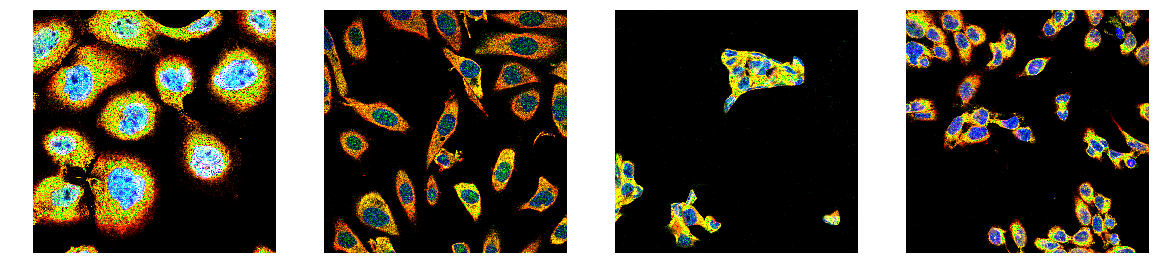

In [24]:
plot_organelles(dset_loaders['train'])

In [25]:
len(dset_loaders['train'])

583

In [ ]:
class MyDenseNetConv(torch.nn.Module):
    def __init__(self, fixed_extractor = True):
        super(MyDenseNetConv,self).__init__()
        original_model = torchvision.models.resnet18(pretrained=True)
        self.features = torch.nn.Sequential(*list(original_model.children())[:-1])
        
        if fixed_extractor:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        x = F.relu(x, inplace=True)
        x = F.avg_pool2d(x, kernel_size=7).view(x.size(0), -1)
        return x

class MyDenseNetDens(torch.nn.Module):
    def __init__(self, nb_out=28):
        super(MyDenseNetDens,self).__init__()
        self.dens1 = torch.nn.Linear(in_features=512, out_features=256)
        self.dens2 = torch.nn.Linear(in_features=256, out_features=256)
        self.dens3 = torch.nn.Linear(in_features=256, out_features=nb_out)
        
    def forward(self, x):
        x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)
        x = self.dens1(x)
        x = torch.nn.functional.selu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.dens2(x)
        x = torch.nn.functional.selu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.dens3(x)
       # x = F.sigmoid(self.dens3(x))
        
        return x

class MyDenseNet(torch.nn.Module):
    def __init__(self):
        super(MyDenseNet,self).__init__()
        self.mrnc = MyDenseNetConv()
        self.mrnd = MyDenseNetDens()
    def forward(self, x):
        x = self.mrnc(x)
        x = self.mrnd(x)
        return x 

In [26]:
class MyDenseNetConv2(torch.nn.Module):
    def __init__(self, fixed_extractor = True):
        super(MyDenseNetConv2,self).__init__()
        original_model = torchvision.models.resnet18(pretrained=True)
        self.features = torch.nn.Sequential(*list(original_model.children())[:-3])
        
        if fixed_extractor:
            for param in self.parameters():
                param.requires_grad = True

    def forward(self, x):
        x = self.features(x)
        x = F.relu(x, inplace=True)
        #x = F.avg_pool2d(x, kernel_size=7).view(x.size(0), -1)
        return x

class MyDenseNetDens2(torch.nn.Module):
    def __init__(self, nb_out=28):
        super(MyDenseNetDens2,self).__init__()
        self.conv1 = torch.nn.Conv2d(256, 512, 5, stride = (2,2))
        self.conv1_bn = torch.nn.BatchNorm2d(512)
        self.dens1 = torch.nn.Linear(in_features=512, out_features=256)
        self.dens2 = torch.nn.Linear(in_features=256, out_features=128)
        self.dens3 = torch.nn.Linear(in_features=128, out_features=nb_out)
        
    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)
        x = self.dens1(x)
        x = torch.nn.functional.selu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.dens2(x)
        x = torch.nn.functional.selu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.dens3(x)
       # x = F.sigmoid(self.dens3(x))
        
        return x

class MyDenseNet2(torch.nn.Module):
    def __init__(self):
        super(MyDenseNet2,self).__init__()
        self.mrnc = MyDenseNetConv2()
        self.mrnd = MyDenseNetDens2()
    def forward(self, x):
        x = self.mrnc(x)
        x = self.mrnd(x)
        return x 

In [27]:
model = MyDenseNet2()
print model

MyDenseNet2(
  (mrnc): MyDenseNetConv2(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
          (relu): ReLU(inplac

In [28]:
total_param= sum(p.numel() for p in model.parameters())
print total_param

6228956


In [29]:
if use_gpu:
    print("Using all GPU's ")
    model = torch.nn.DataParallel(model)
    model.cuda()


Using all GPU's 


In [30]:
import copy

In [31]:
len(dset_loaders['valid'])

195

In [32]:
iterate = list(np.random.permutation(20))
print(iterate)

[18, 5, 7, 15, 0, 11, 6, 8, 17, 3, 10, 16, 19, 1, 4, 13, 2, 14, 12, 9]


In [33]:
def train(criterion,optimizer, model,epochs=10):
    loss_array = []
    loss_array_valid = []
    best_loss = 200000000000000000000
    for epoch in range(epochs):
        
        print('Epoch {}/{}'.format(epoch, epochs - 1))

        running_loss =0.0 
        running_loss_valid = 0.0
        #ii_n_train = len(dset_loaders_train)
        start = time.time()
        iterate = list(np.random.permutation(584))
        print(len(iterate))
        #for i, (inputs, labels) in enumerate(dset_loaders_train):
        for cnt, i in enumerate (iterate):
            string = './TrainFolder/train'+ str(i) + '.npz'
            loaded = np.load(string)
            inputs = loaded['a']
            inputs = torch.from_numpy(inputs)
            labels = loaded['b']
            labels = torch.from_numpy(labels)
            if torch.cuda.is_available():
                inputs = ag.Variable(inputs.cuda(),requires_grad = True)
                labels = ag.Variable(labels.cuda(),requires_grad = False).float()
                #print 1
            #inputs = Variable(inputs)
            #labels = Variable(labels)


            optimizer.zero_grad()
            
            outputs = model.forward(inputs)
            
            loss = criterion(outputs, labels)
            #del(outputs)
            #del(inputs)
            #del(labels)
            loss.backward()

            #Parameter Step
            optimizer.step()

            running_loss += loss[0]

            #loss_array  = []
            print('\rbatch: {}/{}'.format(i, 584))
            if (cnt%6 == 5):   
                #with torch.no_grad():                
                print('[%d ,%5d] loss : %.3f' %(epoch+1,cnt+1,running_loss/6)) #Printing average loss per minibatch summed over 6 mini batches
                
                end = time.time()
                print(end-start)
                start = time.time()
                loss_array.append(float(running_loss/6)) 
                running_loss = 0.0
                torch.save(model.state_dict(), './every_sixth_model2')
            if (cnt%101 == 100 or cnt == 583):
                #for j, (inputs_valid, labels_valid) in enumerate(dset_loaders_valid):
                for j in range(195):
                    print(j)
                    string = './ValidFolder/valid'+ str(j) + '.npz'
                    loaded = np.load(string)
                    inputs_valid = loaded['a']
                    inputs_valid = torch.from_numpy(inputs_valid)
                    labels_valid = loaded['b']
                    labels_valid = torch.from_numpy(labels_valid)
                    if torch.cuda.is_available():
                        inputs_valid = ag.Variable(inputs_valid.cuda(),requires_grad = False, volatile=True)
                        labels_valid = ag.Variable(labels_valid.cuda(),requires_grad = False, volatile=True).float()
                        #optimizer.zero_grad()
                    model = model.eval()
                    outputs_valid = model.forward(inputs_valid)
                    loss_valid = criterion(outputs_valid, labels_valid)
                    del inputs_valid
                    del labels_valid
                    del outputs_valid
                    running_loss_valid += loss_valid.data[0]
                if running_loss_valid/195.0 < best_loss:
                    best_loss = running_loss_valid/195.0
                    torch.save(model.state_dict(), './best_model2')
                    print('best loss : %.3f' %(best_loss))
                #else: 
                    #model.load_state_dict(torch.load('./best_model2'))
                model = model.train()
                print('valid loss : %.3f' %(running_loss_valid/ 195.0))
                loss_array_valid.append(float(running_loss_valid/195.0))
                running_loss_valid = 0.0
    print('Finished Training!')    
    return loss_array, loss_array_valid

In [34]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss,self).__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [35]:
gamma = 0.05
rho = 0.9
criterion = FocalLoss()
optimizer = torch.optim.SGD(model.module.parameters(),lr=gamma, momentum = rho)

In [36]:
loss_train_array, loss_valid_array = train(criterion,optimizer,model,1)

Epoch 0/0
584
batch: 86/584
batch: 44/584
batch: 140/584
batch: 339/584
batch: 239/584
batch: 574/584
[1 ,    6] loss : 2.809
4.63786697388
batch: 53/584
batch: 366/584
batch: 494/584
batch: 454/584
batch: 84/584
batch: 74/584
[1 ,   12] loss : 2.104
2.61602902412
batch: 26/584
batch: 336/584
batch: 177/584
batch: 535/584
batch: 446/584
batch: 487/584
[1 ,   18] loss : 1.822
2.60452103615
batch: 255/584
batch: 120/584
batch: 60/584
batch: 398/584
batch: 158/584
batch: 258/584
[1 ,   24] loss : 1.981
2.94153881073
batch: 344/584
batch: 109/584
batch: 486/584
batch: 24/584
batch: 376/584
batch: 369/584
[1 ,   30] loss : 1.750
2.57380104065
batch: 528/584
batch: 183/584
batch: 317/584
batch: 505/584
batch: 296/584
batch: 143/584
[1 ,   36] loss : 1.635
2.5698120594
batch: 50/584
batch: 529/584
batch: 430/584
batch: 459/584
batch: 331/584
batch: 539/584
[1 ,   42] loss : 1.392
3.05459189415
batch: 2/584
batch: 29/584
batch: 461/584
batch: 557/584
batch: 373/584
batch: 337/584
[1 ,   48] lo

122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
best loss : 1.273
valid loss : 1.273
batch: 550/584
batch: 354/584
batch: 64/584
[1 ,  306] loss : 1.275
87.8599839211
batch: 291/584
batch: 98/584
batch: 247/584
batch: 554/584
batch: 309/584
batch: 139/584
[1 ,  312] loss : 1.291
2.90770888329
batch: 159/584
batch: 581/584
batch: 48/584
batch: 411/584
batch: 189/584
batch: 299/584
[1 ,  318] loss : 1.178
2.75221705437
batch: 101/584
batch: 316/584
batch: 479/584
batch: 579/584
batch: 96/584
batch: 266/584
[1 ,  324] loss : 1.257
3.16530513763
batch: 533/584
batch: 87/584
batch: 210/584
batch: 304/584
batch: 466/584
batch: 448/584
[1 ,  330] loss : 1.308
3.0706589222
batch: 121/584
batch: 59/584
batch: 93/584
batch: 91/584
batch: 534/584
batch: 502

155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
valid loss : 1.217
Finished Training!


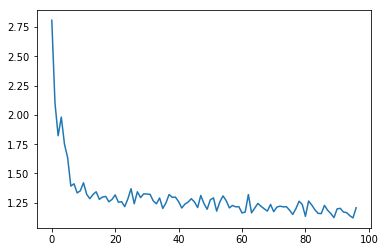

In [37]:
plt.plot(loss_train_array)
plt.savefig('./train_loss_unfrozen_lastresnetlayer.png')

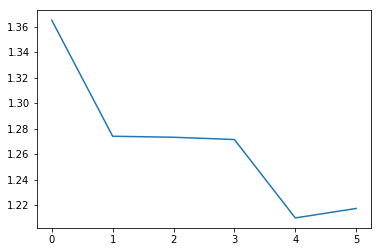

In [38]:
plt.plot(loss_valid_array)
plt.savefig('./train_valid_unfrozen_linear.png')

In [39]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [ ]:
'''thresholds = np.linspace(0, 1, 1500)
score = 0.0
best_threshold=0.0
best_val = 0.0
for threshold in thresholds:
    score = f1_score(valid_y > 0.5, preds_y > threshold, average='macro')
    if score > best_val:
        best_threshold = threshold
        best_val = score
    print("Threshold %0.4f, F1: %0.4f" % (threshold,score))

print("BEST: %0.5f, F1: %0.5f" % (best_threshold,best_val))
'''

In [40]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

In [41]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(28)
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [42]:
from sklearn.metrics import f1_score
import scipy.optimize as opt

In [43]:
#to get F1 score on test data
preds_arr= np.zeros((195*32,28))
labels_arr= np.zeros((195*32,28))
model = model.eval()
start=time.time()
#new_arr = np.zeros((195*32,3,512,512))
#new_arr = np.zeros((195*32,28))
for i in range(194):
    string = './TestFolder/test'+ str(i) + '.npz'
    loaded = np.load(string)
    inputs = loaded['a']
    labels = loaded['b']
    inputs = torch.from_numpy(inputs)
    #labels = torch.from_numpy(labels)
    inputs = ag.Variable(inputs.cuda(),requires_grad = True)
    #labels = ag.Variable(labels.cuda(),requires_grad = False).float()
    preds = model(inputs)
    preds = preds.cpu()
    preds = preds.data.numpy()
    
    #labels = labels.numpy()
    #labels = labels.cpu()
    #preds = np.stack(preds, axis=-1)
    preds = sigmoid_np(preds)
    preds_arr[i*32:(i+1)*32,:] = preds
    labels_arr[i*32:(i+1)*32,:] = labels
    #preds = preds.max(axis=-1)
    #print(preds.shape)
    #print(labels.shape)


In [ ]:
#to get F1 score on train data
preds_arr= np.zeros((584*32,28))
labels_arr= np.zeros((584*32,28))
model = model.eval()
start=time.time()
#new_arr = np.zeros((195*32,3,512,512))
#new_arr = np.zeros((195*32,28))
for i in range(583):
    string = './TrainFolder/train'+ str(i) + '.npz'
    loaded = np.load(string)
    inputs = loaded['a']
    labels = loaded['b']
    inputs = torch.from_numpy(inputs)
    #labels = torch.from_numpy(labels)
    inputs = ag.Variable(inputs.cuda(),requires_grad = True)
    #labels = ag.Variable(labels.cuda(),requires_grad = False).float()
    preds = model(inputs)
    preds = preds.cpu()
    preds = preds.data.numpy()
    
    #labels = labels.numpy()
    #labels = labels.cpu()
    #preds = np.stack(preds, axis=-1)
    preds = sigmoid_np(preds)
    preds_arr[i*32:(i+1)*32,:] = preds
    labels_arr[i*32:(i+1)*32,:] = labels
    #preds = preds.max(axis=-1)
    #print(preds.shape)
    #print(labels.shape)

In [44]:
    print('F1 macro (th = 0.5): ',f1_score(labels_arr, preds_arr>=0.5, average='macro'))
    th = fit_val(preds,labels)
    th[th<0.1] = 0.1
    print('Thresholds: ',th)
    print('F1 macro: ',f1_score(labels_arr, preds_arr>th, average='macro'))
    #print('F1 macro (th = 0.5): ',f1_score(labels, preds>0.5, average='macro'))
    #print('F1 micro: ',f1_score(labels, preds>th, average='micro'))
    #print(outputs_test.shape)
    
    end=time.time()
    print(end-start)

/opt/conda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('F1 macro (th = 0.5): ', 0.0631857206514216)
('Thresholds: ', array([1.11934897, 0.1       , 0.3604126 , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.1       ,
       0.5       , 0.1       , 0.5       , 0.5       , 0.1       ,
       0.5       , 0.1       , 0.5       , 0.1       , 0.1257904 ,
       0.40836089, 0.5       , 0.5       ]))
('F1 macro: ', 0.0867793866109595)
108.113281965


/opt/conda/lib/python2.7/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 5800.
  warnings.warn(errors[info][0], RuntimeWarning)
